# Classifying long vs short life in LFP/Graphite cells 👬

### In this notebook, we are using binary logistic regression to classify long vs short lived cells, based on the efforts of Severson et. al in "Data-driven prediction of battery cycle life before capacity degradation" 💻 

### This is a second part of the project. Most of the functions are defined in the first part, where linear regression was used to predict the cycle life of the same cells 🥈
---------------------------------

## We must again first load the data 📊

In [25]:
import pickle

def load_batches(paths):
    all_cells = {}
    for path in paths:
        with open(path, 'rb') as f:
            batch = pickle.load(f)
        all_cells.update(batch)
    return all_cells

batch_paths = ['../data/batch1.pkl', '../data/batch2.pkl', '../data/batch3.pkl']
cells = load_batches(batch_paths)

## Now, we need to make and train our models 👨‍🍼

To get started, we'll load functions from our other notebook into a namespace `ns`.

In [51]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import nbformat, ast

def load_functions_from_ipynb(path, function_names):

    namespace = {}

    with open(path) as f:
        nb = nbformat.read(f, as_version=4)

    # These cells are talking about the markdown/code cells in the other ipynb -- NOT the battery cells
    for cell in nb.cells:
        
        if cell.cell_type != "code":
            continue

        parsed = ast.parse(cell.source)
        for node in parsed.body:
            if isinstance(node, ast.FunctionDef) and node.name in function_names:
                exec(compile(ast.Module([node], []), filename="<ast>", mode="exec"), namespace)

    
    namespace['np'] = np
    namespace['cells'] = cells # battery cells loaded from load_batches into the namespace, not the markdown/code cells of the ipynb file
    namespace['train_test_split'] = train_test_split
    namespace['RobustScaler'] = RobustScaler

    return namespace

function_names = ['extract_features_simple', 'extract_features_full', 'create_X_y_arrays', 'split_and_fit', ]

ns = load_functions_from_ipynb(r"1_Cycle-life-prediction-using-interpretable-ML.ipynb", function_names)

The next step is to create the feature and target arrays.

In [52]:
X_simple, y_numeric = ns['create_X_y_arrays'](ns['extract_features_simple'])
X_full, _  = ns['create_X_y_arrays'](ns['extract_features_full'])

cycle_threshold = 550 # number of cycles used to say if it's a short or long-lived cell
y = [1 if y_numeric[i] >= cycle_threshold else 0 for i in range(len(y_numeric))]

With the feature and target arrays in hand, we will use our `split_and_fit` function from the other notebook, with the `LogisticRegression` model from `sklearn.linear_model`. First, we'll train the logistic regression model on the simple features, then on the full features.

In [53]:
from sklearn.linear_model import LogisticRegression

y_train, y_test, y_pred_train_simple, y_pred_test_simple = ns['split_and_fit'](X_simple, y, LogisticRegression(), exponentiate = False)

y_train, y_test, y_pred_train_full, y_pred_test_full = ns['split_and_fit'](X_full, y, LogisticRegression(), exponentiate = False)

## Finally, lets compare the models and see how well they predict 🤼‍♂️🔬

We'll use confusion matrices, where values along the top left - bottom right diagonal are correct.

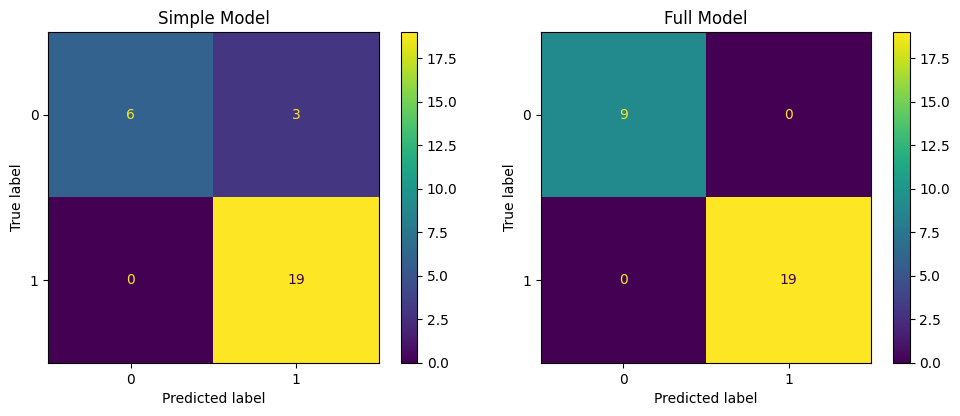

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_simple, ax=axs[0])
axs[0].set_title("Simple Model")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_full, ax=axs[1])
axs[1].set_title("Full Model")

plt.tight_layout()
plt.show()

So, the simple model based only on cycle 10 to cycle 100 voltage variance actually performs very strongly. But, the full model is able to predict even better. In this exact set up, the full model predicts the test data with no errors. 

## Comparison to the original Severson project ⚖️

Up to this point, I have used the same features I used for cycle life prediction for classification. However, there is a downside to this: the features used gather data all the way up to the 100th cycle. Severson et al. were able to get reasonable predictive power using only the first 5 cycles, which offers massive advantages in terms of cost and time savings. 

So, I'll redo the former models using only the first 5 cycles, and see if we can still get reasonable performance. (Instead of comparing the 10th cycle to the 100th for the simple model, I'll use the 1st and 5th.)

/Users/edmund/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


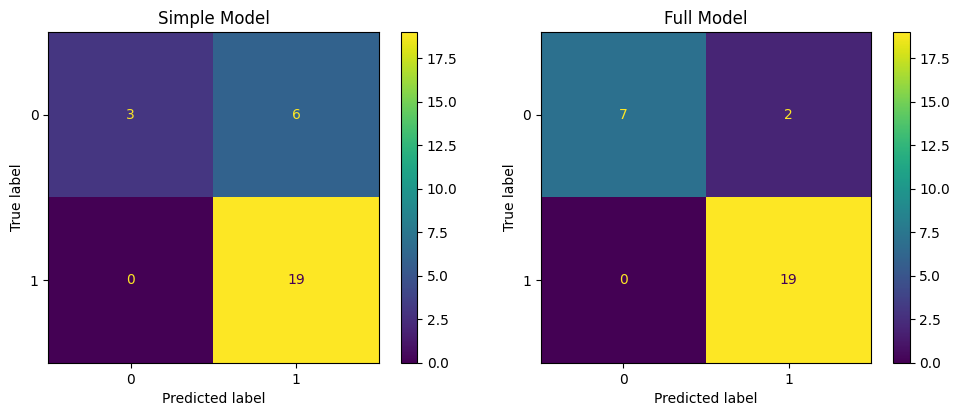

In [57]:
ref_cycle, max_cycle = 1, 5

# Getting feature and target matrices
X_simple, y_numeric = ns['create_X_y_arrays'](ns['extract_features_simple'], ref_cycle, max_cycle)
X_full, _  = ns['create_X_y_arrays'](ns['extract_features_full'], ref_cycle, max_cycle)
y = [1 if y_numeric[i] >= cycle_threshold else 0 for i in range(len(y_numeric))]

# Split, fit, and train
y_train, y_test, y_pred_train_simple, y_pred_test_simple = ns['split_and_fit'](X_simple, y, LogisticRegression(), exponentiate = False)
y_train, y_test, y_pred_train_full, y_pred_test_full = ns['split_and_fit'](X_full, y, LogisticRegression(), exponentiate = False)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_simple, ax=axs[0])
axs[0].set_title("Simple Model")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_full, ax=axs[1])
axs[1].set_title("Full Model")

plt.tight_layout()
plt.show()

So, with using only 5 cycles, we have `22/28 = 79%` accuracy for the simple model, and `26/28 = 93%` accuracy, which is comparable to the numbers obtained by Severson et al.

## Conclusion 🫀

It is very reassuring that cells -- at least commercial LFP/graphite cells like the ones analyzed here -- can be classified into short and long life from fairly limited cycle life data.